In [1]:
import numpy as np, h5py
from PIL import Image
import sys
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from utils.preprocessing import *
from utils.template_match_target import *
import os
%matplotlib inline

def pix2coord(x, y, pixbd, llbd):
    """NEWLY PROGRAMMED"""
    long = (x / float(pixbd[0])) * (llbd[1] - llbd[0]) + llbd[0]
    lat = llbd[3] - (y / float(pixbd[1])) * (llbd[3] - llbd[2])
    return long, lat

## Plot crater dists

In [2]:
# Open image, inport crater files
img_global = Image.open('utils/LunarLROLrocKaguya_118mperpix.png').convert("L")

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/PIL/Image.py:2274: DecompressionBombWarning: Image size (2831155200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [10]:
def coord2pix(long, lat, pixbd, llbd):
    """NEWLY PROGRAMMED"""
    x = (long - llbd[0]) / (llbd[1] - llbd[0]) * pixbd[0]
    y = (llbd[3] - lat) / (llbd[3] - llbd[2]) * pixbd[1]
    return x, y

def cropcraters(craters, llbd):
    return craters[(craters.T[0] >= llbd[0]) & (craters.T[0] < llbd[1]) &
                   (craters.T[1] >= llbd[2]) & (craters.T[1] < llbd[3])]

def plot_craters(craters,GT_craters,xc,yc,rawlen):
    box = np.array([xc, yc, xc + rawlen, yc + rawlen], dtype='int32')

    img = img_global.crop(box)
    llbd = pix2coord(box[0::2], box[1::2], img_global.size, [-180., 180., -60., 60.])
    llbd = np.concatenate([llbd[0], llbd[1][::-1]])
    ctrs_sub = cropcraters(craters, llbd)
    GTctrs_sub = cropcraters(GT_craters, llbd)

    x, y = coord2pix(ctrs_sub.T[0], ctrs_sub.T[1], img.size, llbd)
    r = ctrs_sub.T[2]/((llbd[3]-llbd[2])*(np.pi / 180.0)*(1737.4/(box[2]-box[0])))

    GTx, GTy = coord2pix(GTctrs_sub.T[0], GTctrs_sub.T[1], img.size, llbd)
    GTr = GTctrs_sub.T[2]/((llbd[3]-llbd[2])*(np.pi / 180.0)*(1737.4/(box[2]-box[0])))

    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[25, 10])
    plt.tight_layout()
    img = np.asanyarray(img)
    min_, max_ = np.min(img), np.max(img)
    ax1.imshow(img, cmap='Greys_r', vmin=min_, vmax=max_)
    ax1.set_title(llbd, fontsize=20)
    ax2.imshow(img, cmap='Greys_r', vmin=min_, vmax=max_)
    ax2.set_title('Pred', fontsize=20)
    ax3.imshow(img, cmap='Greys_r', vmin=min_, vmax=max_)
    ax3.set_title('GT', fontsize=20)
    for k in range(len(ctrs_sub)):
        circle = plt.Circle((x[k], y[k]), r[k], color='blue', fill=False, alpha=0.5)
        ax2.add_artist(circle)
    for k in range(len(GTctrs_sub)):
        circle = plt.Circle((GTx[k], GTy[k]), GTr[k], color='red', fill=False, alpha=0.5)
        ax3.add_artist(circle)
    plt.savefig('output_dir/images/remap/llt%s_rt%s_xc%d_yc%d_rawlen%d.png'%(llt,rt,xc,yc,rawlen))
    plt.close()

In [6]:
# get pred
dtype='dev'
llt, rt = '1.40', '0.20'
craters = np.load('datasets/HEAD/HEAD_%s_craterdist_llt%s_rt%s_final.npy'%(dtype,llt,rt))

# get GT
truthalan = pd.read_csv('utils/alanalldata.csv')
truthhead = pd.read_csv('utils/LolaLargeLunarCraterCatalog.csv')
truthhead = truthhead[(truthhead['Lat']>=-60)&(truthhead['Lat']<=60)]
truthalan = truthalan[(truthalan['Lat']>=-60)&(truthalan['Lat']<=60)]
if dtype == 'test':
    truthalan = truthalan[truthalan['Long']>60]        #region of test data
    truthhead = truthhead[(truthhead['Lon']>60)&(truthhead['Diam_km']>20.)]
elif dtype == 'dev':
    truthalan = truthalan[(truthalan['Long']>-60)&(truthalan['Long']<60)]        #region of test data
    truthhead = truthhead[(truthhead['Lon']<60)&(truthhead['Lon']>-60)&(truthhead['Diam_km']>20.)]

rad = np.concatenate((truthalan['Diameter (km)'].values/2.,truthhead['Diam_km'].values/2.))
long = np.concatenate((truthalan['Long'].values,truthhead['Lon'].values))
lat = np.concatenate((truthalan['Lat'].values,truthhead['Lat'].values))

GT_craters = np.column_stack((long, lat, rad))

In [8]:
# plot individual
#xp,yp,rawlen = 0.6,0.5,5000   #long/lat as percentage of dev coord. 0-1 range
xp,yp,rawlen = 0.7,0.7,5000

xc = xp*img_global.size[0]/3 + img_global.size[0]/3
yc = yp*img_global.size[1]
#xc, yc, rawlen = 52000, 18500, 2000

plot_craters(craters,GT_craters,xc,yc,rawlen)

## plot all areas of dev

In [11]:
rawlen = 5000
Nx = int((61400.-30800)/rawlen)
Ny = int(28000./rawlen)
xc, yc = 30800, 0

for j in range(Ny):
    for i in range(Nx):
        print("%d of %d"%(i+Nx*j,Nx*Ny))
        plot_craters(craters,GT_craters,xc,yc,rawlen)
        xc += rawlen
    xc = 30800
    yc += rawlen

0 of 30
1 of 30
2 of 30
3 of 30
4 of 30
5 of 30
6 of 30
7 of 30
8 of 30
9 of 30
10 of 30
11 of 30
12 of 30
13 of 30
14 of 30
15 of 30
16 of 30
17 of 30
18 of 30
19 of 30
20 of 30
21 of 30
22 of 30
23 of 30
24 of 30
25 of 30
26 of 30
27 of 30
28 of 30
29 of 30


## radius of craters (pixels) vs. rawlen

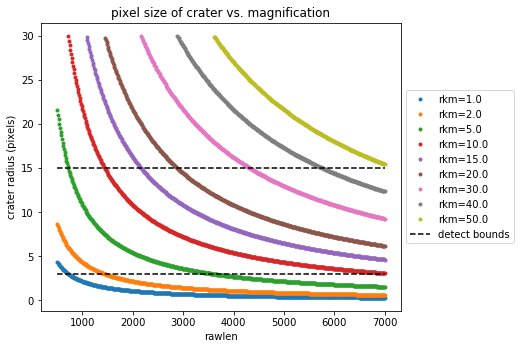

In [80]:
#automated
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.5,0.8])
rawlens = np.linspace(500,7000,500)
for rkm in [1,2,5,10,15,20,30,40,50]:
    bound, r = [], []
    for rawlen in rawlens:
        rpix = rkm/((rawlen/256.)*(np.pi / 180.0)*(1737.4/256))
        if rpix < 30:
            r.append(rpix)
            bound.append(rawlen)
    ax.plot(bound,r,'.',label='rkm=%.1f'%rkm)
ax.plot([min(rawlens),max(rawlens)],[15,15],'k--',label='detect bounds')
ax.plot([min(rawlens),max(rawlens)],[3,3],'k--')
leg = ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5),ncol=1)
ax.set_ylabel('crater radius (pixels)')
ax.set_xlabel('rawlen')
ax.set_title('pixel size of crater vs. magnification')
plt.savefig('output_dir/images/pix_vs_rawlen.png')

## Plot predictions for a given area
Run image_with_coordinates.py to get a few images that contains the region of interest, then plot

In [ ]:
os.system("umount /Users/silburt/remotemount")
os.system("umount /Users/silburt/remotemount2")

In [2]:
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/m/mhvk/czhu/moondata/final_data/ /Users/silburt/remotemount/")
dirssh = '/Users/silburt/remotemount'
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/r/rein/silburt/moon-craters/datasets/HEAD/ /Users/silburt/remotemount2/")
dirssh2 = '/Users/silburt/remotemount2'

In [4]:
dtype = 'dev'
imgs = h5py.File('%s/%s_images.hdf5'%(dirssh,dtype), 'r')
preds = h5py.File('%s/HEAD_%spreds_n30000_final.hdf5'%(dirssh2,dtype), 'r')[dtype]

In [5]:
def get_id(i, zeropad=5):
    return 'img_{i:0{zp}d}'.format(i=i, zp=zeropad)

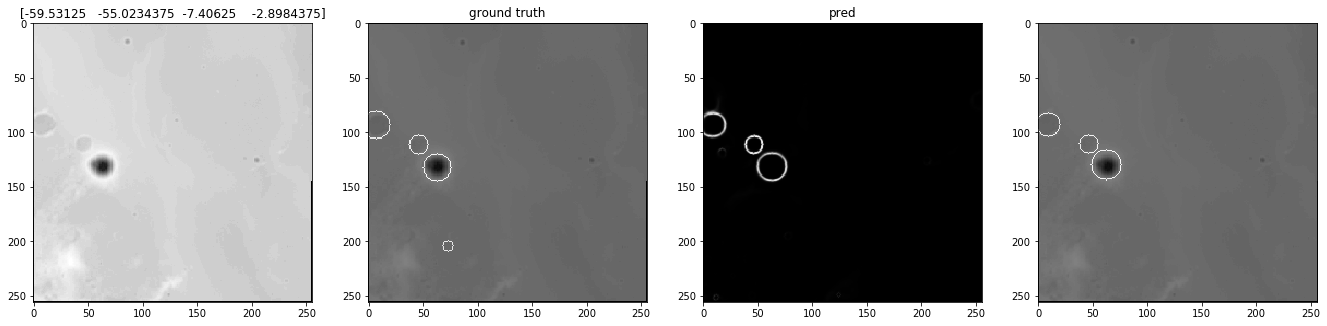

In [7]:
i=3    #large craters: 49, 865, 1, 622
#i=665     #small craters: 538
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[23, 8])

img = imgs['input_images'][i]/255.
minn, maxx = np.min(img[img>0]), np.max(img[img>0])
img[img>0] = 0.1 + (img[img>0] - minn)*(0.9)/(maxx - minn) #linear re-scaling

pred = preds[i].copy()
#pred[pred < 0.1] = 0
#pred[pred >= 0.1] = 1

ax1.imshow(img,origin='upper',cmap="Greys_r")
ax2.imshow(img,origin='upper',cmap="Greys_r")
ax2.imshow(imgs['target_masks'][i],origin='upper', cmap="Greys_r",alpha=0.5)
#ax3.imshow(img,origin='upper',cmap="Greys_r")
ax3.imshow(pred,origin='upper', cmap="Greys_r",alpha=1)

ax1.set_title(imgs['longlat_bounds'][get_id(i)][...])
ax2.set_title('ground truth')
ax3.set_title('pred')

########### extract crater dist ###########
minrad=10
maxrad=50
llt2=70
rt=1
template_thresh=0.6
target_thresh=0.1
coords = template_match_target(pred,minrad=minrad,maxrad=maxrad,longlat_thresh2=llt2,
                               rad_thresh=rt,template_thresh=template_thresh,
                               target_thresh=target_thresh)
cimg = cv2.cvtColor(pred.astype(np.uint8), cv2.COLOR_GRAY2BGR) 
for c in coords:
    x,y,r = c
    cv2.circle(cimg,(int(x),int(y)),int(r),(255,255,255),thickness=1)
ax4.imshow(img,origin='upper', cmap="Greys_r")
ax4.imshow(cimg,origin='upper', cmap="Greys_r",alpha=0.5)
ax4.set_title('pred + image')
########### extract crater dist ###########

#plt.savefig('output_dir/images/large_circ_errs/img%d_tt%.2f.png'%(i,template_thresh))